In [1]:
import matplotlib.style as style

%matplotlib inline
# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (16, 10)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#eeeeee'
#rcParams['grid.color'] = 'white'
#rcParams['axes.facecolor'] = '#eeeeee'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 16
rcParams['patch.edgecolor'] = 'none'

In [2]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error as mse


/Users/dimitriostheoharatos/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Start by reading in our data and breaking it down into our training and hold out set. I will do a 80-20 split since I only have ~300 samples. 

In [3]:
data = pd.read_csv('cleaned_data.csv', index_col = 0)

In [4]:
data.describe()

,0 beds,1 bath,1 bed,1 bedroom,1 guest,1 private bath,1 shared bath,1.5 baths,1.5 private baths,1.5 shared baths,...,plus,price,ratings,rental_price_norm,reviews,superhost,entire_place,private_room,no_baths,shared_room
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,...,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,0.005917,0.547337,0.704142,0.786982,0.050296,0.153846,0.142012,0.005917,0.008876,0.023669,...,0.035503,99.029586,4.835799,1.011284,240.467456,0.662722,0.526627,0.337278,0.020710,0.029586
std,0.076809,0.498492,0.457104,0.410047,0.218879,0.361336,0.349580,0.076809,0.093931,0.152240,...,0.185322,41.822208,0.247461,0.097043,127.503420,0.473482,0.500031,0.473482,0.142623,0.169693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,25.000000,4.000000,0.823382,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,69.000000,4.500000,0.927301,152.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,92.000000,5.000000,1.010097,224.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,125.000000,5.000000,1.055299,310.750000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,333.000000,5.000000,1.172587,808.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's drop the id information since it will not be necessary in our analysis. 

In [5]:
data = data.drop(['id'], axis = 1)

# Exploratory Data Analysis

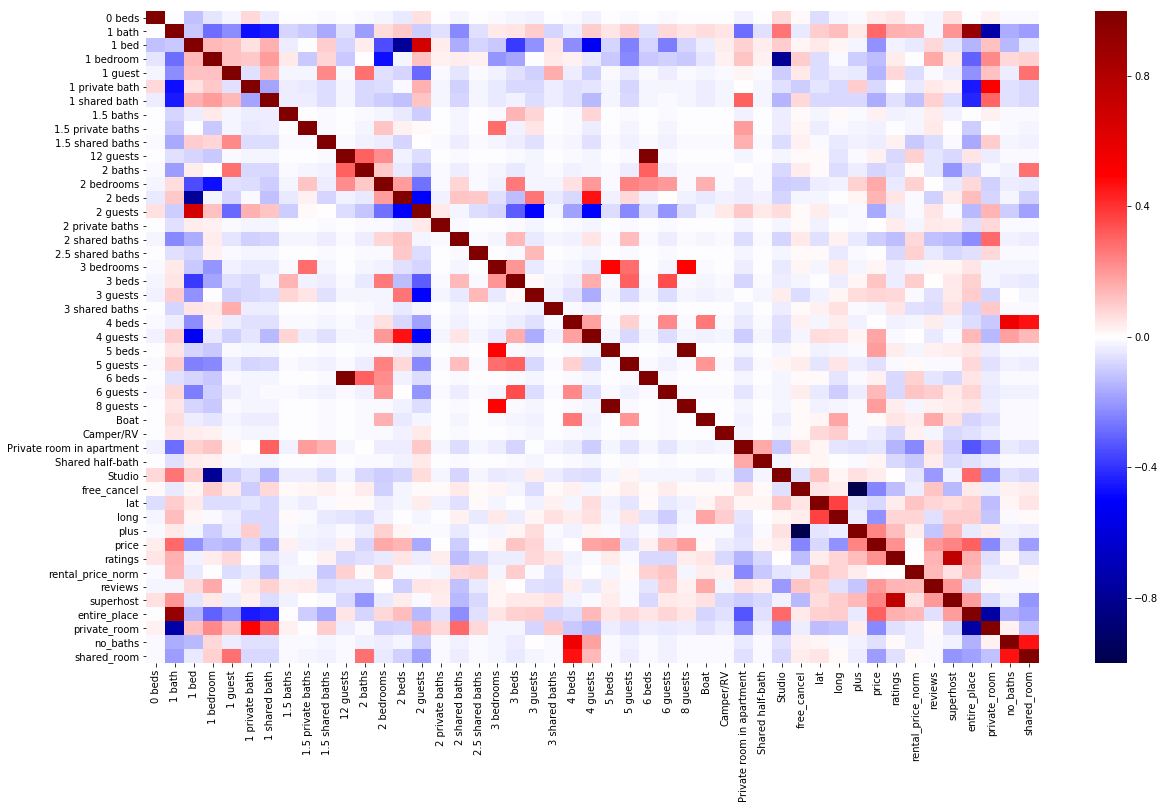

In [14]:
rcParams['figure.figsize'] = (20, 12)
fig, ax = plt.subplots()
sns.heatmap(data.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1, ax = ax)
fig.savefig('heatmap.svg', format = 'svg')

Looking at the heatmap of our matrix, I notice a couple of things. Our target variable, price, is not strongly correlated with many of features except for entire place, free cancel, and 1 bath.  Also, a couple of our features are seemingly completely correlated- 12 guests and 6 beds as well as 8 guests and 5 beds. The likely scenario is that there are one or only a couple sample points that satisfy these conditions allowing for perfect collinearity. I check for this below: 

In [282]:
X['12 guests'].corr(X['6 beds']), X['8 guests'].corr(X['5 beds'])

(1.0, 1.0)

In [283]:
data[data['12 guests'] & data['6 beds'] == 1]

,0 beds,1 bath,1 bed,1 bedroom,1 guest,1 private bath,1 shared bath,1.5 baths,1.5 private baths,1.5 shared baths,...,plus,price,ratings,rental_price_norm,reviews,superhost,entire_place,private_room,no_baths,shared_room
269,0,0,0,0,0,0,0,0,0,0,...,0,117,4.5,1.172587,117,0,1,0,0,0


In [284]:
data[data['8 guests'] & data['5 beds'] == 1]

,0 beds,1 bath,1 bed,1 bedroom,1 guest,1 private bath,1 shared bath,1.5 baths,1.5 private baths,1.5 shared baths,...,plus,price,ratings,rental_price_norm,reviews,superhost,entire_place,private_room,no_baths,shared_room
122,0,1,0,0,0,0,0,0,0,0,...,0,245,5.0,0.983213,310,1,1,0,0,0


As expected, there is only one row for each of these.  We can get rid of one each of these features since we are not extracting any additional value from them by including completely dependent features. 

In [285]:
data = data.drop(['12 guests', '8 guests'], axis = 1)

One bath and entire place are also highly correlated as shown below, but they are not entirely linearly dependent so will keep them both as features for now.

In [286]:
data['1 bath'].corr(data['entire_place'])

0.9115830908828518

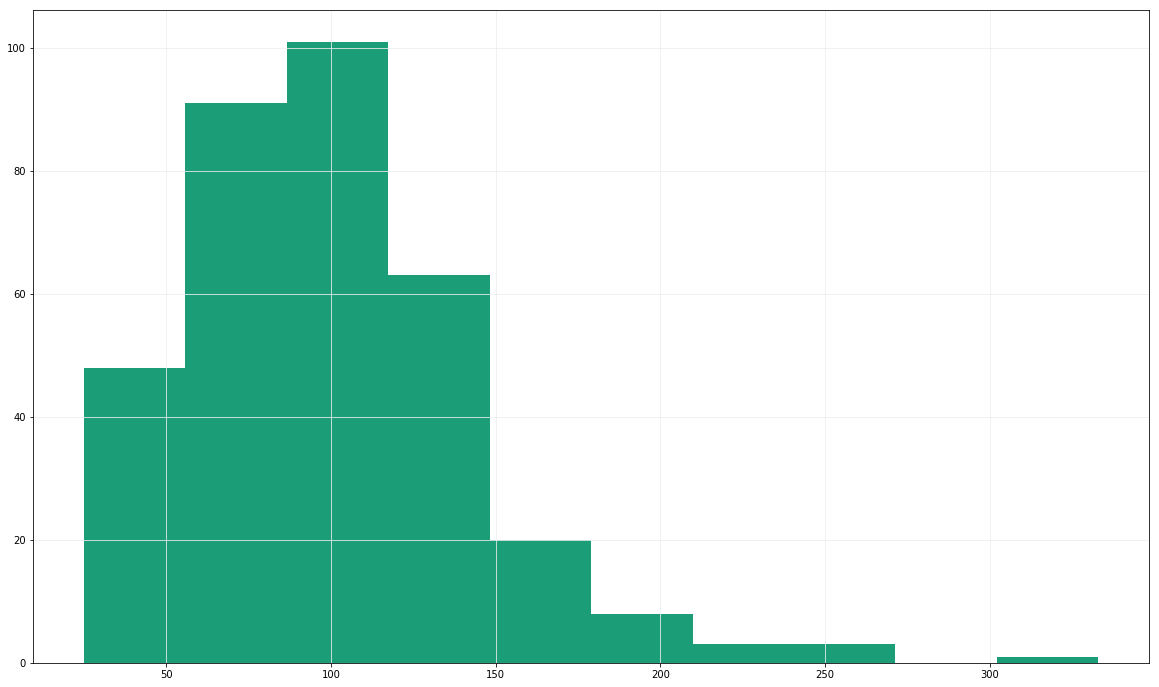

In [16]:
plt.hist(data.price)
plt.show()

It looks like there is a serious right skew in this data set, with a couple of larger outliers pulling on the distribution.  Let's take a logarithmic transformation of our target variable to include as a possible candidate for our response variable.

Let's see if we can perform a transformation on our target variable to see if we can locate more correlated features. 

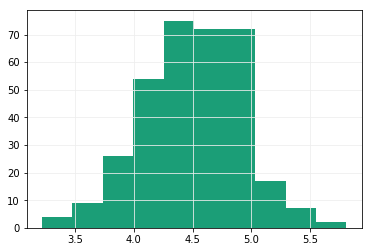

In [8]:
data['sqrt_price'] = np.log(data.price)
plt.hist(data.sqrt_price)
plt.show()

Since most of our variables are categorical in nature, we cannot do many transformations to our feature space. However, there are a few continuous variables, namely rental_price_norm, reviews, and ratings.  Let's investigate these continuous features further. 

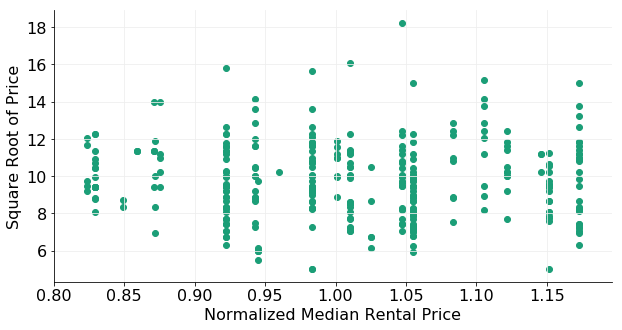

In [50]:
plt.figure(figsize=(10,5))
rcParams['font.size'] = 16

plt.scatter(data.rental_price_norm,data.sqrt_price)
plt.ylabel('Square Root of Price')
plt.xlabel('Normalized Median Rental Price')
sns.despine()

It looks like the normalized rental price feature, the feature which I created, has no correlation at all to the price of the AirBnB listing.  

Maybe the raw lattitude and longtiude data will be more illuminating:


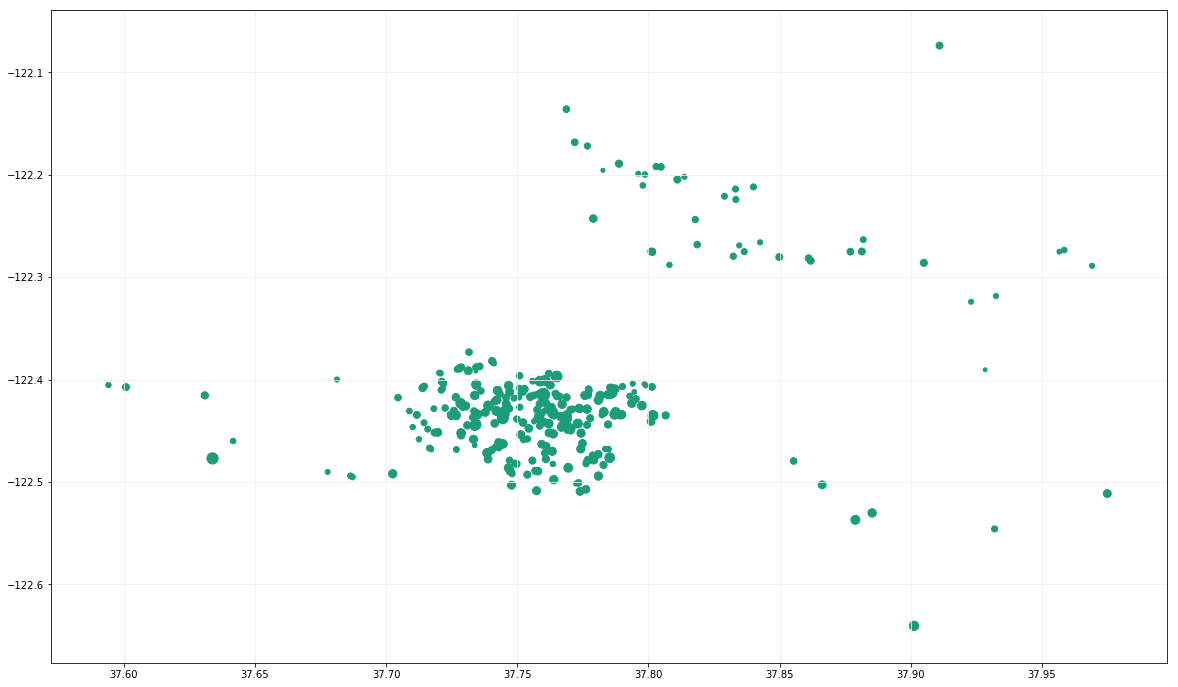

In [19]:
plt.scatter(data.lat, data.long, s = data.price/2)

It's diffilcult to decipher from the visualization, but it does seem that the lattitude and longitudes closer to 37.75 and -122.45 are on average higher in price relative to some of the points in the North East. 

Let's look into ratings and reviews as well. 

In [29]:
ratings_means = [np.mean(data.sqrt_price[data.ratings == 4]), np.mean(data.sqrt_price[data.ratings == 4.5]), \
                 np.mean(data.sqrt_price[data.ratings == 5])]

In [30]:
ratings_means

[7.764151616036334, 9.188164752973567, 10.028122305443919]

In [28]:
data['sqrt_price'] = data.price**0.5

In [ ]:
da

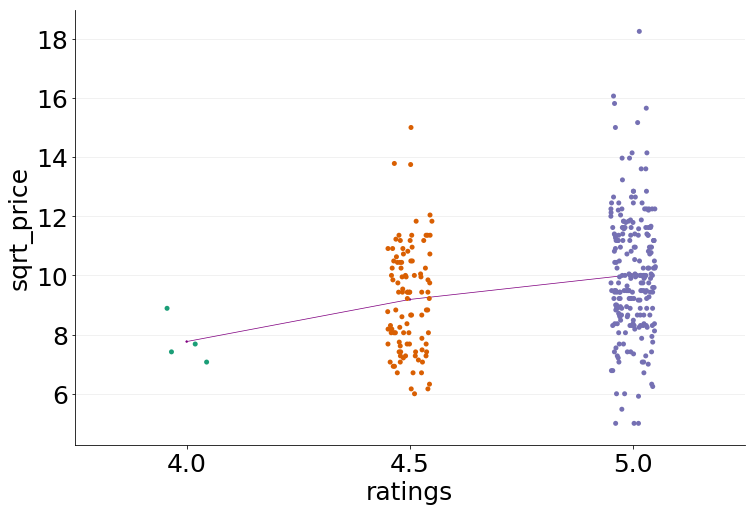

In [33]:
#style.use('fivethirtyeight')
plt.figure(figsize=(12,8))
rcParams['font.size'] = 25
sns.stripplot(data.ratings,data.sqrt_price, jitter = True, size = 5)
sns.pointplot([4, 4.5, 5], ratings_means, scale = 0.2, color = 'purple')

sns.despine()

Based on the above plot, there is clearly a relationship between the the ratings a user receives and the price, illustrated by the line connecting each rating that is placed at the mean of each cluster.  Note that a jitter was added to the above plot to get a sense of the number of hosts with each rating (4, 4.5, 5). 

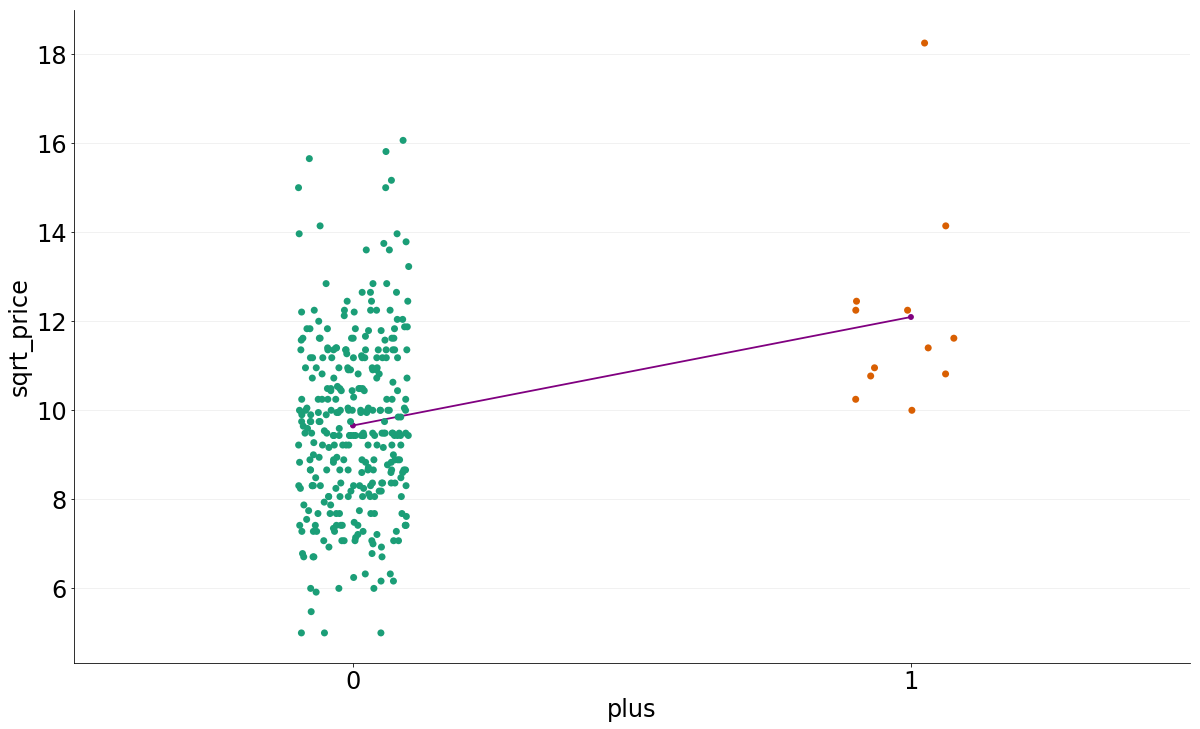

In [52]:
rcParams['font.size'] = 24
plus_means = [np.mean(data.sqrt_price[data.plus == 0.0]), np.mean(data.sqrt_price[data.plus == 1.0])]
sns.stripplot(data.plus,data.sqrt_price, jitter = True, size = 7)
sns.pointplot([0,1], plus_means, scale = 0.5, color = 'purple')
sns.despine()

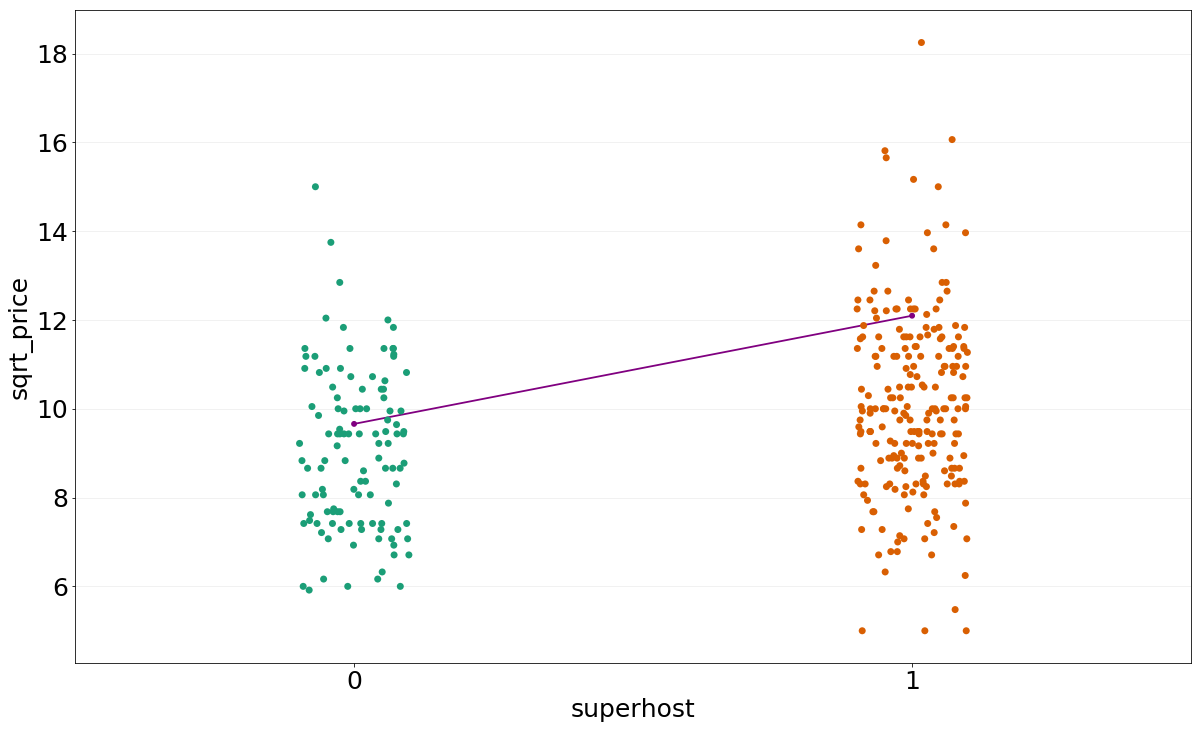

In [45]:
superhost_means = [np.mean(data.sqrt_price[data.superhost == 0.0]), np.mean(data.sqrt_price[data.superhost == 1.0])]
sns.stripplot(data.superhost,data.sqrt_price, jitter = True, size = 7)
sns.pointplot([0,1], plus_means, scale = 0.5, color = 'purple')


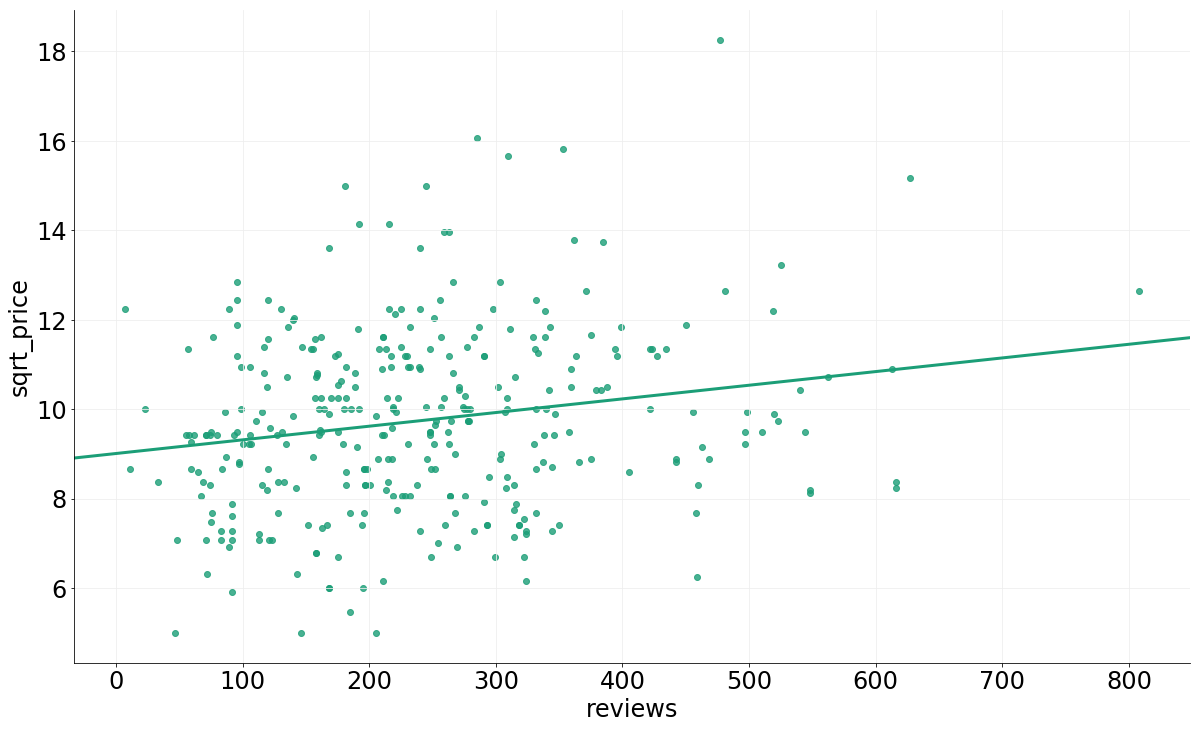

In [53]:
sns.regplot(data.reviews, data.sqrt_price, ci = None)
sns.despine()

It also looks like reviews has a linear relationship, though there is certinaly a lot of variance.  

Rather than manually removing additional features that are uncorrelated, let's instead couple polynomial regression with regularization techniques. 

Finally, let's store our data frame into a final file to be read to begin modeling in a new notebook. 

In [292]:
data.head()

,0 beds,1 bath,1 bed,1 bedroom,1 guest,1 private bath,1 shared bath,1.5 baths,1.5 private baths,1.5 shared baths,...,price,ratings,rental_price_norm,reviews,superhost,entire_place,private_room,no_baths,shared_room,logprice
0,0,1,1,1,0,0,0,0,0,0,...,120,5.0,1.001234,239,1,1,0,0,0,4.787492
1,0,1,1,1,0,0,0,0,0,0,...,101,5.0,1.010097,219,1,1,0,0,0,4.615121
2,0,0,1,1,0,0,1,0,0,0,...,53,4.5,1.172587,324,0,0,1,0,0,3.970292
3,0,1,1,1,0,0,0,0,0,0,...,68,5.0,1.172587,616,1,1,0,0,0,4.219508
4,0,1,0,0,0,0,0,0,0,0,...,149,5.0,1.047322,339,1,1,0,0,0,5.003946


In [293]:
data.to_csv('modeling_data.csv')